In [3]:
import time
import os
import sys
import numpy as np
from fast_histogram import histogram1d, histogram2d
import matplotlib as mpl
#mpl.use('agg')
import hmf
from Functions import Functions as F
import multiprocessing
from numba import jit
from colossus.cosmology import cosmology
from colossus.halo.mass_defs import changeMassDefinition as CMD
from colossus.halo.mass_defs import pseudoEvolve as PE
from colossus.lss import mass_function
from colossus.halo.concentration import concentration as get_c
from colossus.halo.mass_so import M_to_R
from scipy.interpolate import interp1d
from halotools import empirical_models
from astropy.cosmology import Planck15 as Cosmo_AstroPy
plt = mpl.pyplot
plt.ion(); plt.show()
T1 = time.time()
cosmology.setCosmology("planck15")
Cosmo = cosmology.getCurrent()
h = Cosmo.h
h_3 = h*h*h

#Get the HMF (Halo Mass Function) according to Murray et al. 2013
#https://arxiv.org/abs/1306.6721
HMF_fun = F.Make_HMF_Interp()

#set to True for better HM/SM resolution, takes MUCH longer
HighRes = False

#Cuts in Satellite mass
SM_Cuts = [9, 9.5, 10, 10.5, 11, 11.45]#[9,10,11]#
#When using Abundance matching do N realisations to capture upscatter effects
N = 5

#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': True,\
'B18c':True,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False,\
'HMevo': False,\
'HMevo_param': None\
}

Paramaters_Glob = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}


#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}


In [2]:
#Calculate Halo Mass (z), van den Bosch

#HaloMass Limits and Bins
AnalyticHaloMass_min = 11.0; AnalyticHaloMass_max = 16.6
if HighRes:
    AnalyticHaloBin = 0.05
else:
    AnalyticHaloBin = 0.1
#AHB_2 = AnalyticHaloBin*AnalyticHaloBin #Not used
AnalyticHaloMass = np.arange(AnalyticHaloMass_min + np.log10(h), AnalyticHaloMass_max + np.log10(h), AnalyticHaloBin) #Create array in the Halo Mass range
#Units are in M_virial * h^-1
#Read https://arxiv.org/abs/1308.4150

#This is the Halomass growth history
#Generates redshfit steps that are small enough to avoid systematics.
z, AvaHaloMass_wz = F.Get_HM_History(AnalyticHaloMass, AnalyticHaloMass_min, AnalyticHaloMass_max, AnalyticHaloBin)
AvaHaloMass = AvaHaloMass_wz[:, 1:] #Avarage Halo Mass for each redshift (M,N), units of [log10 Msun]

#Account for central bin shrinking
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

In [3]:
HM_vdB = AvaHaloMass
HM_vdB_Bins = AvaHaloMassBins
z_vdB = z

In [7]:
np.savetxt('HM_vdB.dat', HM_vdB)

(0.1, 4)

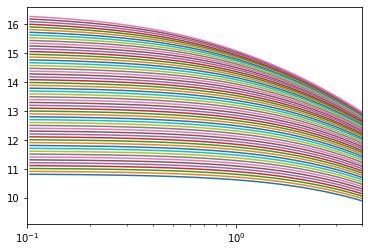

In [4]:
plt.figure()
for i in range(0,HM_vdB[0,:].size):
    plt.semilogx(z_vdB, HM_vdB[:,i])
plt.xlim(0.1,4)

In [1]:
#Get SMHM from catalog, Behroozi

import pandas as pd
path = 'Data/Observational/Behroozi_catalog/'
file_name = 'sfr_catalog_0.994717.txt'
#data = pd.read_table(path+file_name, header = None)

In [4]:
HM=np.loadtxt(path+file_name, usecols=11)

In [9]:
SM=np.loadtxt(path+file_name, usecols=18)

In [36]:
SMHM=np.loadtxt(path+file_name, usecols=24)

In [10]:
print(SM)
#print(np.log10(SMHM*HM))
print(np.log10(HM))

[ 0.952093 -0.473326  1.166795 ...  0.030428  1.009998  0.117336]
[14.16256441  8.5653755   9.10037055 ...  8.65867903  8.65867903
  8.83486558]


In [7]:
plt.figure()
plt.plot(np.log10(HM), np.log10(SM))

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x181dd4e5f0> (for post_execute):


OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 432x288 with 1 Axes>

(11, 15)

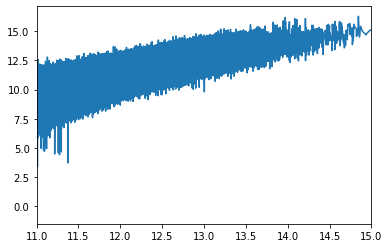

In [76]:
hm_idx=np.argsort(HM)
hm=HM[hm_idx]
sm=SM[hm_idx]
smhm=SMHM[hm_idx]
plt.figure()
#plt.plot(np.linspace(0,1,hm.size),np.log10(hm),',')
#func=interp1d(HM,SMHM*HM)
plt.plot(np.log10(hm),np.log10(smhm*hm))
plt.xlim(11,15)

In [1]:
print(smhm)

NameError: name 'smhm' is not defined

In [281]:
#Get SMHM from catalog, Behroozi

path = 'Data/Observational/Behroozi_catalog/data/smhm/median_raw/'

file_names = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)) and 'smhm_a' in i:
        file_names.append(i)
a = np.zeros(len(file_names))
for i in range(0, len(file_names)):
    a[i] = float(file_names[i][6:14])
for i in range(0,a.size):
    if (a[i]>=1.):
        idx_to_be_removed = i
        file_names.remove('smhm_a'+str(a[i])+'.dat')
a = np.delete(a, idx_to_be_removed)
z = 1./a - 1.
idx = np.argsort(z)
smhm = []
for i in idx:
    smhm.append(np.loadtxt(path+file_names[i],usecols=(0,1)))
    #print(np.loadtxt(path+file_names[i],usecols=(0,1)))
    #print(np.shape(np.loadtxt(path+file_names[i],usecols=(0,1))))

z = np.sort(z)
#print(np.shape(smhm))
SMHM = np.zeros((z.size, smhm[0][:,0].size, smhm[0][0,:].size))
for i in range(0, z.size):
    for j in range(0, SMHM[i,:,0].size):
        for k in range(0, SMHM[i,j,:].size):
            SMHM[i,j,0] = smhm[i][j,0]
            SMHM[i,j,1] = smhm[i][j,1]
            #print(k)
            #print(smhm[i][j,1])


21
21


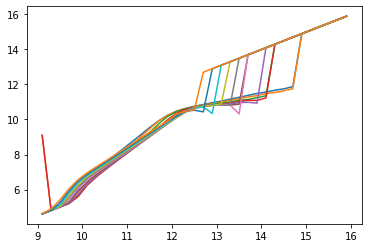

In [292]:
plt.figure()
print(z.size)
print(SMHM[:,0,1].size)
for i in range(0,z.size):
    if (z[i]<=6.):
        plt.plot(SMHM[i,:,0],SMHM[i,:,1]+SMHM[i,:,0],label='z = {}'.format(z[i]))
     #print(SMHM[i,0,1])
#plt.legend(loc = 'lower right')

In [237]:
print(np.shape(smhm))
print(np.shape(SMHM))
print(SMHM[0,0,0])
#print(z)
#print(z_vdB)

(21, 35, 2)
(21, 35, 2)
-4.494999


In [229]:
def find_HM_idx_vdB(z_idx_vdB, HM_des, HM_vdB):
    for i in range(0, HM_vdB[z_idx_vdB,:].size):
        if (HM_vdB[z_idx_vdB,i]>=HM_des):
            if (i==0):
                HM_idx_vdB = i
                break
            elif (i>0):
                diff1 = np.abs(HM_des-HM_vdB[z_idx_vdB,i-1])
                diff2 = np.abs(HM_des-HM_vdB[z_idx_vdB,i])
                if (diff1<diff2):
                    HM_idx_vdB = i-1
                    break
                elif (diff2<diff1):
                    HM_idx_vdB = i
                    break
    return HM_idx_vdB

In [236]:
z_idx_max = 0
for i in range(0,z.size): #search for z_idx_max in Behroozi, because z_vdB stops at 6, while Behroozi at 10
    if (z[i]>np.max(z_vdB) and z[i-1]<=np.max(z_vdB)):
        z_idx_max=i-1

Mstar_to_be_avaraged = np.zeros(SMHM[0,0,:].size)
HM_desired_z0 = [10., 10.5, 11.]
Mstar = []
for i in HM_desired_z0:
    Mstar.append(np.zeros(z.size))
idx = []
z_idx_vdB = []
for i in range(0, z_idx_max+1):
    for k in range(0,z_vdB.size): #loop to find index in z_vdB
        if (z_vdB[k]>=z[i]):
            if (k==0):
                z_idx_vdB.append(k)
                break
            elif (k>0):
                diff1 = np.abs(z[i]-z_vdB[k-1])
                diff2 = np.abs(z[i]-z_vdB[k])
                if (diff1<diff2):
                    z_idx_vdB.append(k-1)
                    break
                elif (diff2<diff1):
                    z_idx_vdB.append(k)
                    break
                else:
                    Err_msg = 'No index in z_vdB found for the {}th value of z'.format(i)
                    sys.exit(Err_msg)
    #print(i)
    #print(z[i])
    #print(z_vdB[z_idx_vdB[i]])

if (len(z_idx_vdB) != z_idx_max+1):
    print('len(z_idx_vdB) = {}'.format(len(z_idx_vdB)))
    print('z.size = {}'.format(z.size))
    Err_msg = 'Size of z_idx_vdB is different from that of z!'
    sys.exit(Err_msg)

plt.figure()
for j in range(0, z_idx_max+1): #loop on redshifts
    for i in range(0, len(HM_desired_z0)): #loop on HM_z0 desired
        HM_idx_vdB_z0 = find_HM_idx_vdB(z_idx_vdB[0], HM_desired_z0[i], HM_vdB)
        #print(z_idx_vdB[j])
        #print(HM_idx_vdB_z0)
        HM_desired = HM_vdB[j, HM_idx_vdB_z0]
        HM_idx_vdB = find_HM_idx_vdB(z_idx_vdB[j], HM_desired, HM_vdB)
        Mstar_to_be_avaraged = SMHM[j,HM_idx_vdB,1]
        if j == 0:
            print(SMHM[j,HM_idx_vdB,1])
        #Mstar[i][j] =np.median(Mstar_to_be_avaraged)
        #print(j)
        #print(SMHM[j,HM_idx_vdB,:].size)
    #plt.semilogx(z, Mstar[i])
#plt.xlim(0.1,4.)

-4.494999
-4.494999
-4.494956


<Figure size 432x288 with 0 Axes>